In [77]:
import numpy as np
import scipy.io
import xarray as xr
import os
import pandas as pd
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import cmocean.cm as cmo

import warnings
warnings.filterwarnings('ignore')

from data_loading import get_altimetry_data, get_2021_CTD_data, get_CTD_all_years, get_CTD
import warnings

<xarray.Dataset>
Dimensions:      (time: 931, depth: 2901)
Coordinates:
  * time         (time) datetime64[ns] 2010-05-25T11:36:00.000005 ... 2019-07...
  * depth        (depth) float64 0.0 0.9921 1.984 ... 2.856e+03 2.857e+03
    idx          (time) int64 0 1 2 3 4 5 6 7 ... 111 112 113 114 115 116 117
    latitude     (time) float64 43.0 42.75 42.51 42.26 ... 42.67 42.83 42.92
    longitude    (time) float64 6.001 5.996 6.003 6.006 ... 6.133 6.131 6.132
Data variables:
    temperature  (time, depth) float64 nan nan 18.84 18.53 ... nan nan nan nan
    salinity     (time, depth) float64 nan nan 37.67 37.65 ... nan nan nan nan

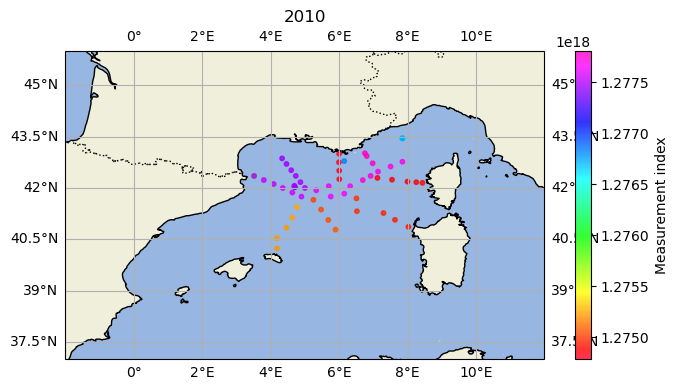

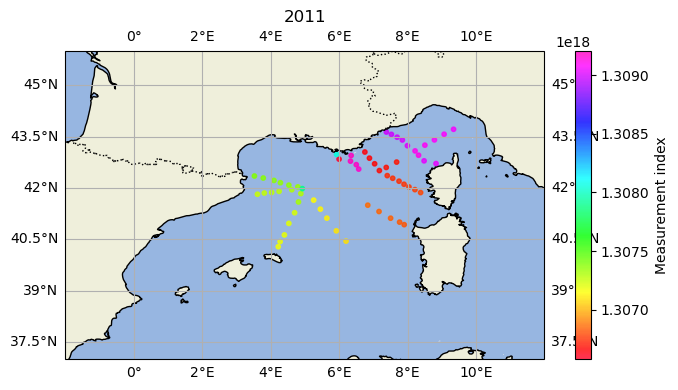

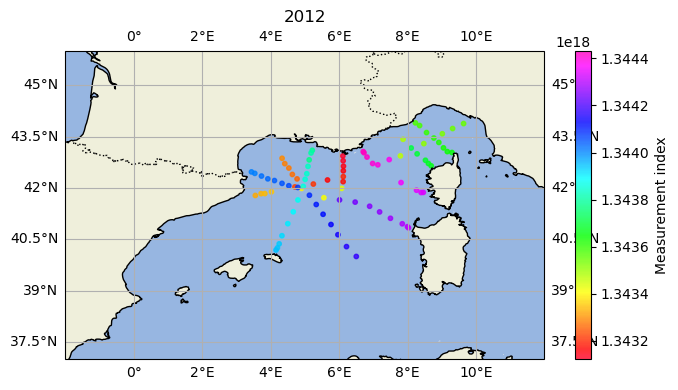

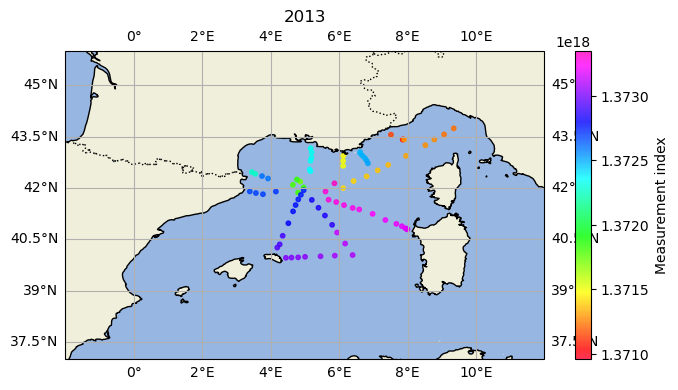

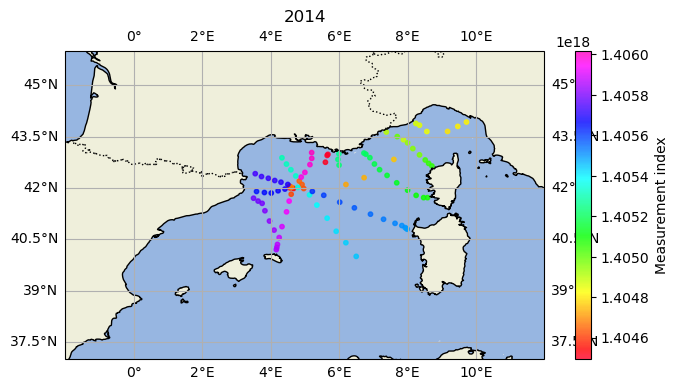

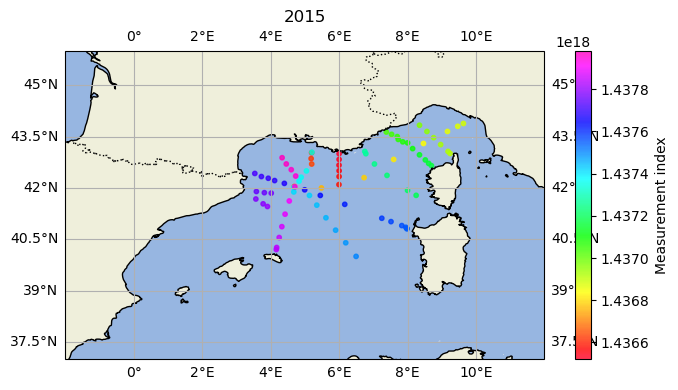

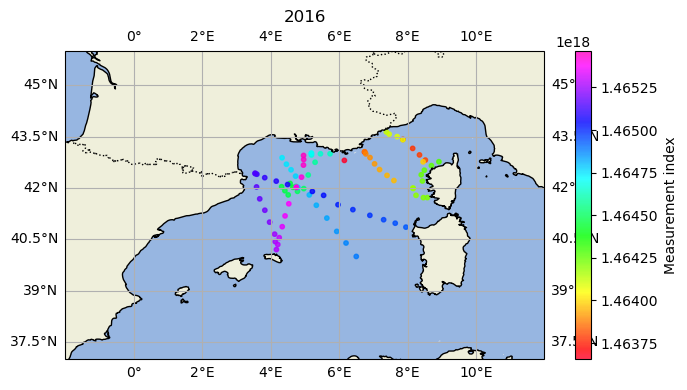

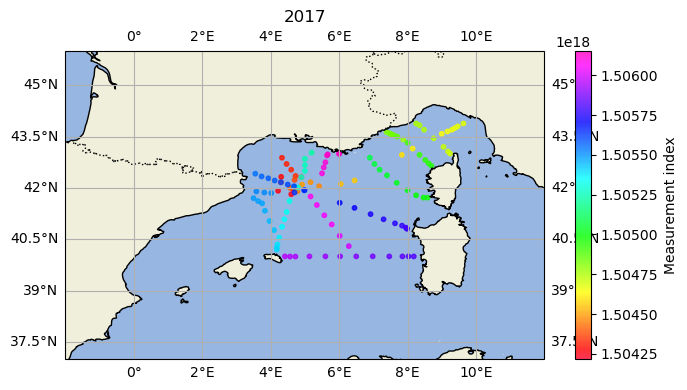

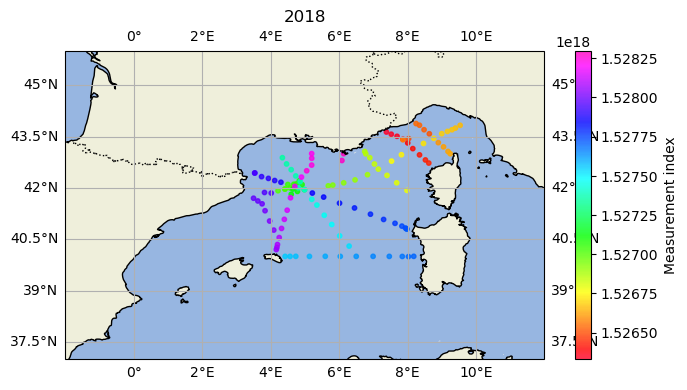

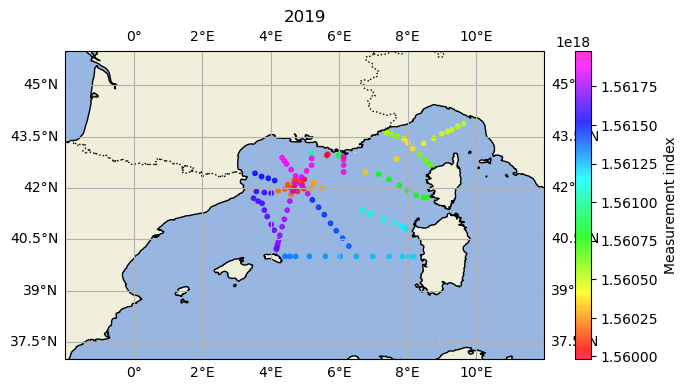

In [78]:
ds = get_CTD_all_years()

years = list(range(2010, 2020))

for year in years:
    ds = get_CTD(year)

    fig, ax = plt.subplots(figsize=(8,4), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-2, 12, 37, 46])
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.OCEAN)
    ax.gridlines(draw_labels=True)
    sc = ax.scatter(ds.longitude, ds.latitude, s=10, c=ds.time, cmap='gist_rainbow', alpha=0.8)
    plt.colorbar(sc, ax=ax, label='Measurement index')
    plt.title(f'{year}')
    plt.show()

    

/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


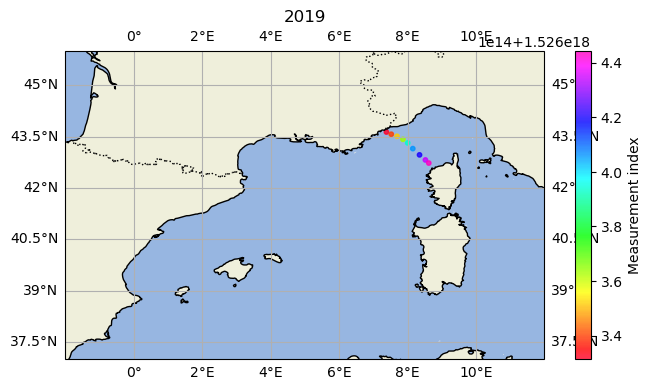

In [25]:
ds = get_CTD(2018).isel(time=slice(0, 9))
fig, ax = plt.subplots(figsize=(8,4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-2, 12, 37, 46])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)
ax.gridlines(draw_labels=True)
sc = ax.scatter(ds.longitude, ds.latitude, s=10, c=ds.time, cmap='gist_rainbow', alpha=0.8)
plt.colorbar(sc, ax=ax, label='Measurement index')
plt.title(f'{year}')
plt.show()

In [28]:
ds

<xarray.Dataset>
Dimensions:      (time: 9, depth: 2901)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-14T20:57:03.666668 ... 2018-05...
  * depth        (depth) float64 0.0 0.9921 1.984 ... 2.856e+03 2.857e+03
    idx          (time) int64 0 1 2 3 4 5 6 7 8
    latitude     (time) float64 43.63 43.57 43.51 43.42 ... 42.97 42.82 42.73
    longitude    (time) float64 7.382 7.525 7.693 7.866 ... 8.35 8.522 8.621
Data variables:
    temperature  (time, depth) float64 nan nan 17.52 17.52 ... nan nan nan nan
    salinity     (time, depth) float64 nan nan 37.89 37.89 ... nan nan nan nan

In [ ]:
ds['density'] = gsw.sigma0(ds.salinity, ds.temperature)

In [95]:
proj = ccrs.Mercator(central_longitude=4.5, min_latitude=38.0, max_latitude=45.0)

def show_section(ds):

    ds = ds.sortby('time')
    ds['idx'] = np.arange(len(ds.time))

    # Trajectory on a map
    fig, ax = plt.subplots(figsize=(10,4), subplot_kw={'projection': proj})
    ax.set_extent([-2, 12, 37, 46])
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.OCEAN)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    sc = ax.scatter(ds.longitude, ds.latitude, s=10, c=ds.idx, cmap='jet', alpha=0.8, transform=ccrs.PlateCarree())
    plt.colorbar(sc, ax=ax, label='Station')
    plt.title(f'Section')
    plt.show()

    ds['density'] = gsw.sigma0(ds.salinity, ds.temperature)

    levels = 50

    D = ds['density'].values
    min_density = np.nanmin(D)
    max_density = np.nanmax(D)

    fig, ax = plt.subplots(figsize=(10,5))
    cmesh = ax.pcolormesh(
        ds.latitude, 
        ds.depth, 
        ds['temperature'].T, 
        cmap=cmo.thermal,
    )
    plt.colorbar(cmesh, ax=ax, label='Temperature [°C]')
    cont = ax.contour(
        ds.latitude, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 15)
    )
    ax.invert_yaxis()
    plt.clabel(cont, fmt='%1.1f')
    plt.xlabel('Latitude')
    plt.ylabel('Depth [m]')
    plt.show()


    fig, ax = plt.subplots(figsize=(10,5))
    cmesh = ax.pcolormesh(
        ds.latitude, 
        ds.depth, 
        ds['salinity'].values.T, 
        cmap=cmo.haline,
    )
    plt.colorbar(cmesh, ax=ax, label='Salinity [g/kg]')
    cont = ax.contour(
        ds.latitude, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 15)
    )
    ax.invert_yaxis()
    plt.clabel(cont, fmt='%1.1f')
    plt.xlabel('Latitude')
    plt.ylabel('Depth [m]')
    plt.show()


    fig, ax = plt.subplots(figsize=(10,5))
    cmesh = ax.pcolormesh(
        ds.latitude, 
        ds.depth, 
        ds['density'].values.T, 
        cmap=cmo.dense,
    )
    plt.colorbar(cmesh, ax=ax, label='Density [g/kg]')
    cont = ax.contour(
        ds.latitude, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 15)
    )
    ax.invert_yaxis()
    plt.clabel(cont, fmt='%1.1f')
    plt.xlabel('Latitude')
    plt.ylabel('Depth [m]')
    plt.show()




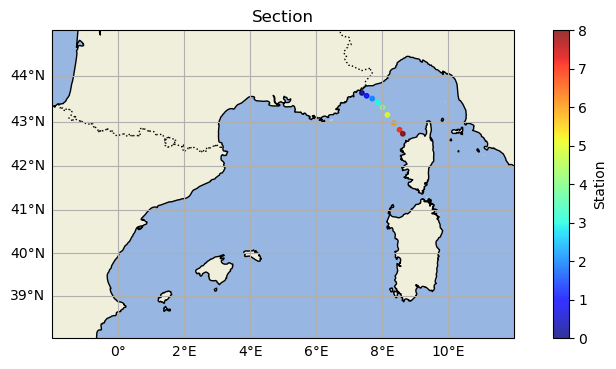

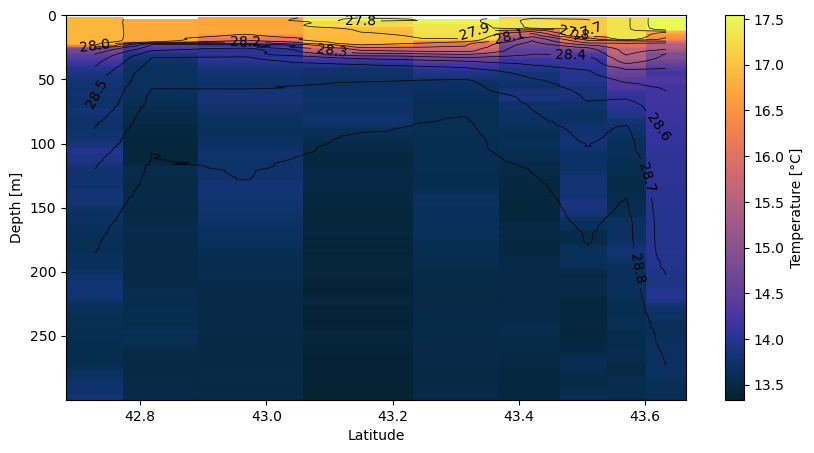

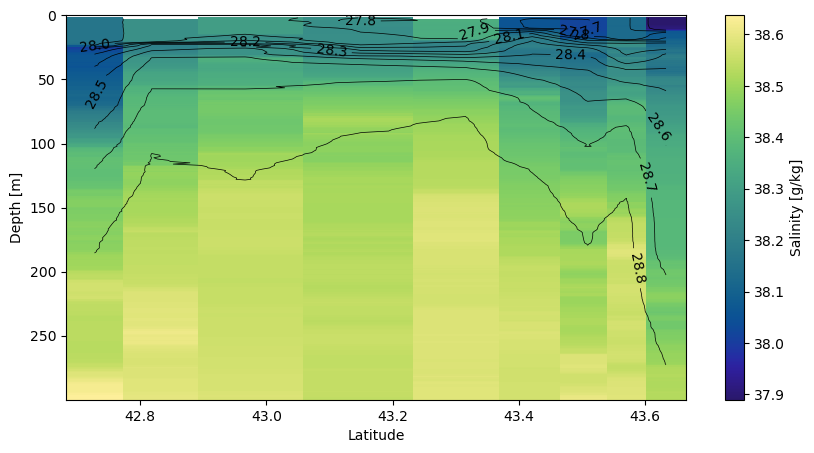

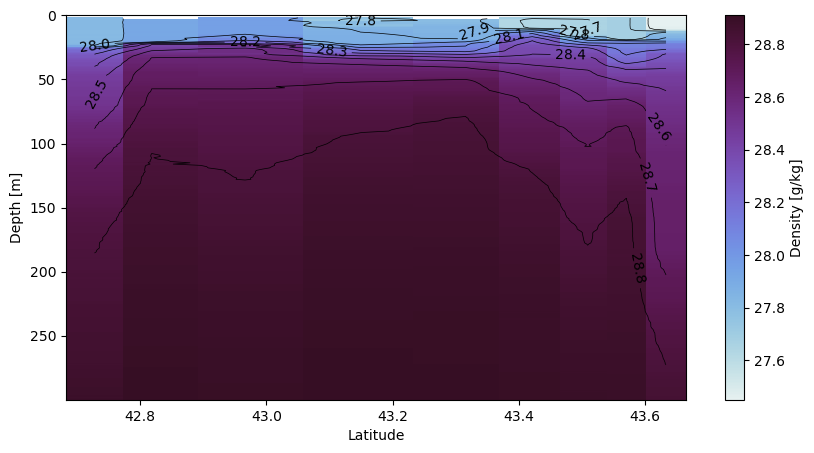

In [96]:
ds = get_CTD(2018).isel(time=slice(0, 9)).sel(depth=slice(0, 300))
show_section(ds)

In [87]:
# T cross section plot
X = ds['temperature'].values

D = ds['density'].values
min_density = np.nanmin(D)
max_density = np.nanmax(D)

fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.contourf(
    ds.latitude, 
    ds.depth, 
    X.T, 
    cmap=cmo.thermal,
    levels=100
)
plt.colorbar(cmesh, ax=ax, label='Temperature [°C]')
cont = ax.contour(
    ds.latitude, 
    ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 15)
)
ax.invert_yaxis()
plt.ylim([200, 0])
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Temperature cross section')
plt.show()


fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.contourf(
    ds.latitude, 
    ds.depth, 
    ds['salinity'].values.T, 
    cmap=cmo.haline,
    levels=100
)
plt.colorbar(cmesh, ax=ax, label='Salinity [g/kg]')
cont = ax.contour(
    ds.latitude, 
    ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 15)
)
ax.invert_yaxis()
plt.ylim([200, 0])
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Temperature cross section')
plt.show()


fig, ax = plt.subplots(figsize=(10,5))
cmesh = ax.contourf(
    ds.latitude, 
    ds.depth, 
    ds['density'].values.T, 
    cmap=cmo.dense,
    levels=100
)
plt.colorbar(cmesh, ax=ax, label='Density [g/kg]')
cont = ax.contour(
    ds.latitude, 
    ds.depth, 
    D.T, 
    colors='black', 
    linewidths=0.5, 
    levels=np.linspace(min_density, max_density, 15)
)
ax.invert_yaxis()
plt.ylim([200, 0])
plt.clabel(cont, fmt='%1.1f')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title('Temperature cross section')
plt.show()

KeyError: 'density'